# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle
import csv
import os

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Make dictionary of sign names from CSV file
with open('signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    sign_names = dict((int(n),label) for n, label in reader)


In [2]:
### To start off let's do a basic data summary.
# # TODO: number of training examples
n_train = len(y_train)

# # TODO: number of testing examples
n_test = len(y_test)

# # TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# # TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


A helper function for plotting images and their labels is defined below. This is based in part, on the plot_images() function in the TensorFlow tutorials at https://github.com/Hvass-Labs/TensorFlow-Tutorials

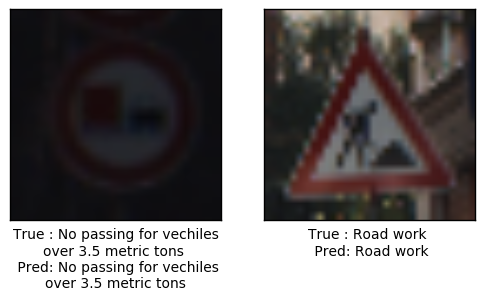

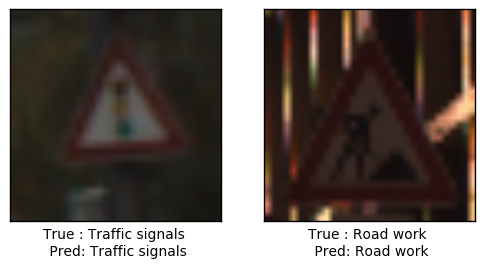

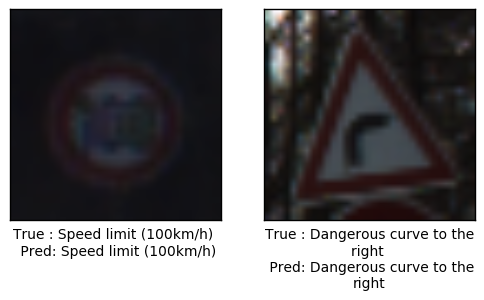

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import textwrap

def plot_images(images, cls_true, cls_pred=None, count=6, num_per_row=2):
    ctr = 0
    global sign_names
    
    for i in random.sample(range(len(images)), count):    
        X, y_true = images[i,:], cls_true[i]

        if ctr % num_per_row == 0:
            # Create new row
            plt.figure()
            
        plt.subplot(1, num_per_row, (ctr % num_per_row) + 1)
        ax = plt.gca()
        plt.imshow(X)
        
        # Show the classes as the label on the x-axis.
        true_label = textwrap.fill(sign_names[y_true], 25)
        if cls_pred is not None:
            y_pred = cls_pred[i]
            pred_label = textwrap.fill(sign_names[y_pred], 25)
            ax.set_xlabel('True : {0} \n Pred: {1}'.format(true_label, pred_label))
        else:
            ax.set_xlabel(true_label)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

        ctr += 1
    
plot_images(X_train, y_train, y_train)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm_notebook
from zipfile import ZipFile
import time
from datetime import timedelta
import math
import tensorflow as tf

In [5]:
def normalize_color(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    
    Xmin = 0.0
    Xmax = 255.0

    norm_img = np.empty_like(image_data, dtype=np.float32)

    norm_img = a + (image_data - Xmin)*(b-a)/(Xmax - Xmin)
    
#     norm_img = tf.image.random_flip_left_right(norm_img)
#     norm_img = tf.image.random_hue(norm_img, max_delta=0.05)
#     norm_img = tf.image.random_contrast(norm_img, lower=0.3, upper=1.0)
#     norm_img = tf.image.random_brightness(norm_img, max_delta=0.2)
#     norm_img = tf.image.random_saturation(norm_img, lower=0.0, upper=2.0)

    return norm_img

train_features = normalize_color(X_train)
test_features = normalize_color(X_test)

In [6]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The images were normalized in all three channels. The dataset was augmented by introducing random rotations ($\pm$ 30 degrees) and translations ($\pm$ 2 pixels). A new Python class `Dataset` was defined to allow accessing the dataset in batches of fixed size. This class makes sure it so that the data rolls over to the beginning if the end of the dataset is reached. Batching is important because of memory limitations that prevent working on the full data set at the same time, during training as well as testing. 

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.

from scipy.misc import imrotate
class Dataset():
    """
    A class that provides an unlimited supply of batched data from a given dataset
    """
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.length = len(features)
        self.reset()
    
    def reset(self):
        self.ctr = 0
        
    def next_batch(self, batch_size):
        """
        Returns an a batch of data, resetting to beginning any time it reaches the end
        """
        indices = np.arange(self.ctr, self.ctr+batch_size) % self.length
        self.ctr += batch_size
        self.ctr = self.ctr % len(self.features)
        
        return self.features[indices], self.labels[indices]

def rand_rotate(image, degrees=30):
    rotated = imrotate(image, np.random.uniform(-degrees, +degrees))
    return rotated

# def rand_scale():
#     pass

def rand_translate(image, shift_px=2):
    out = np.zeros_like(image)
    shift = int(np.random.uniform(-shift_px, +shift_px))
    left = max(0, -shift)
    right= min(image.shape[1], image.shape[1]-shift)
    left_out = max(0, shift)
    right_out = min(image.shape[1], image.shape[1]+shift) 
    
    shift = int(np.random.uniform(-shift_px, +shift_px))
    top = max(0, -shift)
    btm = min(image.shape[1], image.shape[1]-shift)
    top_out = max(0, shift)
    btm_out = min(image.shape[1], image.shape[1]+shift) 
    out[top_out:btm_out,left_out:right_out] = image[top:btm,left:right]
    
    return out
        
# Add perturbed datasets -- rotation (+/- 15 deg) and translation(-2,2 px) ( no scale(0.9-1.1) )
new_features = []
new_labels = []

for img, lbl in tqdm_notebook(zip(train_features, train_labels), unit=' images'):
    rot = rand_rotate(img)
    new_features.append(rot)
    new_labels.append(lbl)
    
    trn = rand_translate(img)

    new_features.append(trn)
    new_labels.append(lbl)
    
train_features = np.concatenate((train_features, np.array(new_features)))
train_labels = np.concatenate((train_labels, np.array(new_labels)))

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=0xdeadbeef)

print('Training features and labels randomized and split.')

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

In [ ]:
def train_linear_model(session, optimizer, cost, train_data, num_iterations, batch_size=256):
    iter_pbar = tqdm_notebook(range(num_iterations), unit=' iterations')
    for ctr in iter_pbar:
        batch_X, batch_y = train_data.next_batch(batch_size)

        feed_dict_train = {X: batch_X, y_true: batch_y}
        _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)

        iter_pbar.set_description('Iteration {0}, Cost : {1}'.format(ctr+1, c))

def get_prediction(session, model, data):
    pred = session.run(model, feed_dict={X: data.features, y_true: data.labels})
    correct = np.equal(pred, np.argmax(data.labels, axis=1))
    acc = sum(correct)/data.length
    
    return y_pred, acc

In [ ]:
# Test on linear model
from skimage import color

img_size_flat = 32*32

lin_pick = range(train_features.shape[0])
lin_train_features = np.zeros((len(lin_pick), img_size_flat))
lin_train_labels = np.zeros((len(lin_pick), n_classes))

lin_test_features = np.zeros((len(test_features), img_size_flat))
lin_test_labels = test_labels

for ctr in range(len(test_labels)):
    img = test_features[ctr]
    lin_test_features[ctr] = np.reshape(color.rgb2gray(img), img_size_flat)

for ctr, i in enumerate(lin_pick):
    img = train_features[i,:,:]

    lin_train_features[ctr] = np.reshape(color.rgb2gray(img), img_size_flat)
    lin_train_labels[ctr] = train_labels[i,:]

lin_train = Dataset(lin_train_features, lin_train_labels)
lin_test = Dataset(lin_test_features, lin_test_labels)

In [ ]:
W1 = tf.Variable(tf.truncated_normal([img_size_flat, n_classes], stddev=0.05))  # Weights
b1 = tf.Variable(tf.zeros([n_classes]))  # biases

# tf Graph input
X = tf.placeholder("float", [None, img_size_flat])   # Flattened images
logits = (tf.matmul(X, W1) + b1)

y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

y_true = tf.placeholder("float", [None, n_classes])

# Compute cost
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost)
init = tf.initialize_all_variables()

In [ ]:
# # Run linear classifier on reduced data-set
# with tf.Session() as session:
#     session.run(init)
#     train_linear_model(session, optimizer, cost, lin_train, 50000)
#     _, train_acc = get_prediction(session, y_pred_cls, lin_train)
#     _, test_acc = get_prediction(session, y_pred_cls, lin_test)

# print('Training Accuracy : %.2f %%' % (train_acc*100))
# print('Test Accuracy : %.2f %%' % (test_acc*100))

**Answer:**

In [12]:
### Define your architecture here.
layer_width = {
    'layer_1': 16,
    'layer_2': 32,
    'layer_3': 64,
    'layer_4': 128,
    'layer_5': 256,

    'fc1': 1024,
    'fc2': 512
}

# Store layers weight & bias
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']], stddev=0.005)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']], stddev=0.005)),
    'layer_4': tf.Variable(tf.truncated_normal(
        [3, 3, layer_width['layer_3'], layer_width['layer_4']], stddev=0.05)),
    'layer_5': tf.Variable(tf.truncated_normal(
        [3, 3, layer_width['layer_4'], layer_width['layer_5']], stddev=0.05)),

    'fc1': tf.Variable(tf.truncated_normal(
        [1024, layer_width['fc1']], stddev=0.05)),
    'fc2': tf.Variable(tf.truncated_normal(
        [layer_width['fc1'], layer_width['fc2']], stddev=0.05)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fc2'], n_classes], stddev=0.05))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'layer_4': tf.Variable(tf.zeros(layer_width['layer_4'])),
    'layer_5': tf.Variable(tf.zeros(layer_width['layer_5'])),
    'fc1': tf.Variable(tf.zeros(layer_width['fc1'])),
    'fc2': tf.Variable(tf.zeros(layer_width['fc2'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

# Create model
def conv_net(x, weights, biases, keep_prob):
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    
    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
#     conv3 = maxpool2d(conv3)
    
    # Layer 4
    conv4 = conv2d(conv3, weights['layer_4'], biases['layer_4'], strides=2)
    conv4 = maxpool2d(conv4)
    conv4 = tf.nn.dropout(conv4, keep_prob)    
    
    # Layer 5
    conv5 = conv2d(conv4, weights['layer_5'], biases['layer_5'], strides=2)
    conv5 = maxpool2d(conv5)
    print(conv5)
    
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv5,
        [-1, weights['fc1'].get_shape().as_list()[0]])

    fc1 = tf.add(tf.matmul(fc1, weights['fc1']), biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fc2'])
    fc2 = tf.nn.relu(fc2)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

# tf Graph input
X = tf.placeholder("float", [None, image_shape[0], image_shape[1], image_shape[2]])
y_true = tf.placeholder("float", [None, n_classes])
y_true_cls = tf.argmax(y_true, dimension=1)
dropout_keep_prob = tf.placeholder('float')

# Create the ConvNet
train_logits = conv_net(X, weights, biases, dropout_keep_prob)

# Compute predicted class
y_pred = tf.nn.softmax(train_logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Feed dicts for training, validation, and test session
train_feed_dict = {X: train_features, y_true: train_labels}
valid_feed_dict = {X: valid_features, y_true: valid_labels}
test_feed_dict = {X: test_features, y_true: test_labels}

Tensor("MaxPool_1:0", shape=(?, 2, 2, 256), dtype=float32)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


### **Answer:**

The final architecture has five convolutional layers and two fully connected layers.

Conv5-Conv5-MaxPool-Dropout-Conv5-MaxPool-Conv3-MaxPool-Dropout-Conv3-MaxPool-FC1-FC2 
= 92% after 10k, 96.62% after 45k

Model3 = Conv5-Conv5-Dropout-Conv5-MaxPool-Conv3-MaxPool-Dropout-Conv3-MaxPool-FC1-FC2 
= 94.88 % after 10k, 97.70% after 100k

The `optimize` function runs one round of optimization on the ConvNet, for a given number of iterations. It prints the test accuracy every 100 iterations as well as the time taken for the entire process.

In [13]:
train_data = Dataset(train_features, train_labels)
test_data = Dataset(test_features, test_labels)
valid_data = Dataset(valid_features, valid_labels)

In [14]:
def train_model(session, optimizer, cost, model, train_data, num_iterations, save_best=True, valid_data=None, batch_size=256, keep_prob=0.5):
    iter_pbar = tqdm_notebook(range(num_iterations), unit=' iterations')

    if save_best:
        global saver, save_dir
        
    best_validation_accuracy = 0.0
    last_improvement = 0
    require_improvement = 1000
    
    save_path = save_dir + 'best_validation'
    
    for ctr in iter_pbar:
        batch_X, batch_y = train_data.next_batch(batch_size)

        feed_dict_train = {X: batch_X, y_true: batch_y, dropout_keep_prob: keep_prob}
        _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)

        if save_best and ((ctr % 1000 == 0) or (ctr == (num_iterations - 1))):
            train_acc = session.run(accuracy, feed_dict={X: batch_X, y_true: batch_y, dropout_keep_prob: 1.0})
            valid_acc = get_validation_accuracy(session, model)

            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = valid_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = ctr

                # Save all variables of the TensorFlow graph to file.
                saver.save(sess=session, save_path=save_path)

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # Shows that no improvement was found.
                improved_str = ''
#             # If no improvement found in the required number of iterations.
#             if ctr - last_improvement > require_improvement:
#                 print("No improvement found in a while, stopping optimization.")

#                 # Break out from the for-loop.
#                 break
            
        iter_pbar.set_description('c={0:>6.4}, train_acc={1:>6.2%}, valid_acc={2:>6.2%}{3}, best={4:>6.2%}'.format(c,
                                                                                          train_acc,
                                                                                          valid_acc,
                                                                                          improved_str,
                                                                                          best_validation_accuracy))
    print("Last improvement at "+str(last_improvement+1))

def get_accuracy(session, model, data, batch_size=421):
    # Number of images in the test-set.
    num_test = data.length

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        batch_images = data.features[i:j, :]

        # Get the associated labels.
        batch_labels = data.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {X: batch_images,
                     y_true: batch_labels,
                     dropout_keep_prob: 1.0}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(model, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    
    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(data.labels, axis=1)
    # Create a boolean array whether each image is correctly classified.
    correct = np.equal(cls_true, cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = sum(correct)

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    return acc, cls_pred

def get_validation_accuracy(session, model):
    valid_acc, _ = get_accuracy(session, model, valid_data, batch_size=256)
    return valid_acc

def get_train_accuracy(session, model):
    train_acc, _ = get_accuracy(session, model, train_data, batch_size=256)
    return train_acc

def print_accuracy():
    train_acc = get_train_accuracy(session, y_pred_cls)
    valid_acc = get_validation_accuracy(session, y_pred_cls)
    
    print('Training Accuracy : %.2f %%' % (train_acc*100))
    print('Validation Accuracy : %.2f %%' % (valid_acc*100))
    
def print_test_accuracy():
    test_acc, _ = get_accuracy(session, y_pred_cls, test_data, batch_size=421)
    print('Test Accuracy : %.2f %%' % (test_acc*100))
    
def plot_wrong_tests():
    test_acc, cls_pred = get_accuracy(session, y_pred_cls, test_data, batch_size=421)
    cls_true = np.argmax(test_data.labels, axis=1)
    
    wrong = np.not_equal(cls_true, cls_pred)
    
    plot_images(test_data.features[wrong], cls_true[wrong], cls_pred[wrong])

In [15]:
# Parameters
learning_rate = 1e-4
batch_size = 64

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits, y_true))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# This is evaluated later when checking accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
session = tf.Session()

In [16]:
saver = tf.train.Saver(tf.all_variables())
save_dir = 'checkpoints/'

In [ ]:
batch_size=64
session.run(tf.initialize_all_variables())
train_model(session, optimizer, cost, y_pred_cls, train_data, 10, batch_size)
print_accuracy()

In [ ]:
# Run 1000 iterations
train_model(session, optimizer, cost, y_pred_cls, train_data, 990, batch_size)
print_accuracy()

In [ ]:
# Run 10000 iterations
train_model(session, optimizer, cost, y_pred_cls, train_data, 9000, batch_size)
print_accuracy()
saver.save(session, save_dir+'mdl3', global_step=10000)

In [ ]:
# Run 50000 iterations
train_model(session, optimizer, cost, y_pred_cls, train_data, 40000, batch_size)
test_acc, _ = get_accuracy(session, y_pred_cls, test_data, batch_size=421)
saver.save(session, save_dir+'mdl3'+str(int(test_acc*100)), global_step=50000)
print_accuracy()

In [ ]:
# saver.save(session, save_dir+'mdl3-96.79', global_step=42000)
train_model(session, optimizer, cost, y_pred_cls, train_data, 58000, batch_size)
test_acc, _ = get_accuracy(session, y_pred_cls, test_data, batch_size=421)
saver.save(session, save_dir+'mdl3'+str(int(test_acc*100)), global_step=100000)
print_accuracy()

In [ ]:
saver.restore(sess=session, save_path=save_dir + 'cnn_97.77_testacc-100000')
# saver.save(session, save_dir+'mdl3-96.91', global_step=90000)
# print_accuracy()
print_test_accuracy()
plot_wrong_tests()
plt.show()

In [ ]:
session.close()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First, I used a simple linear classifier on the dataset. This was primarily done to make sure that my image pre-processing as well as my tensorflow setup was working. In fact, when I first tried blindly implementing a CNN, it didn't work out so well. Implementing the linear classifier helped me find a few bugs in my preprocessing step.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.